# Модульное задание по статистике №1 (задания 1-2)

In [14]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. EDA
Заменим все значения признаков на числовые и посмотрим на наш датасет:

In [15]:
df = pd.read_csv('var1.tsv', sep='\t').dropna()
df.sex = df.sex.apply(lambda x: 1 if x == 'F' else 0)
df.preemie = df.preemie.apply(lambda x: 1 if x else 0)
df.head()

,MomAge,DadAge,MomEduc,sex,weight,preemie
0,35,35.0,17.0,1,3175,0
1,22,21.0,12.0,1,3884,0
2,35,42.0,15.0,1,3030,0
4,23,28.0,13.0,1,3481,0
5,26,31.0,12.0,0,3374,0


Теперь можно посмореть на попарные графики, чтобы найти очевидные зависимости и посмотреть распределения:

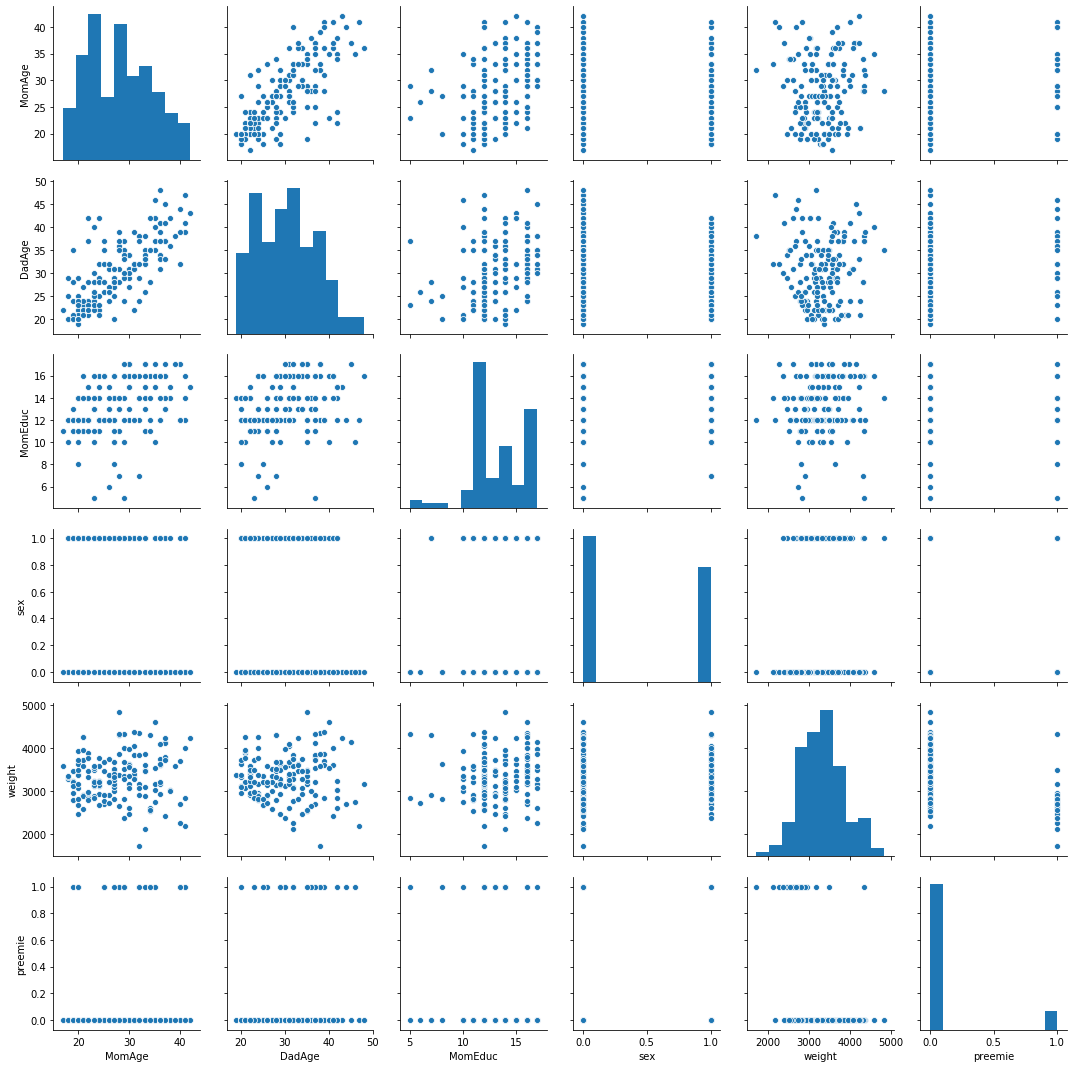

In [3]:
sns.pairplot(df);

Можно увидеть зависимость между возрастом отца и матери, между весом и недоношенностью ребенка, так же видна слабая зависимость между образованием матери и ее возрастом, образованием матери и возрастом отца. Еще можно обратить внимание на вес и пол ребенка. Теперь посчитаем корреляцию между признаками:

In [4]:
df.corr()

,MomAge,DadAge,MomEduc,sex,weight,preemie
MomAge,1.000000,0.741558,0.367846,-0.152605,0.069559,0.132340
DadAge,0.741558,1.000000,0.337135,-0.075980,0.013795,0.142728
MomEduc,0.367846,0.337135,1.000000,0.019372,0.106673,-0.083338
sex,-0.152605,-0.075980,0.019372,1.000000,0.016839,-0.076954
weight,0.069559,0.013795,0.106673,0.016839,1.000000,-0.391770
preemie,0.132340,0.142728,-0.083338,-0.076954,-0.391770,1.000000


Самая высокая корреляция между возрастом отца и матери - 0.74 и между весом и недоношенностью - -0.39. Для наглядности представим корреляцию на хитмапе:

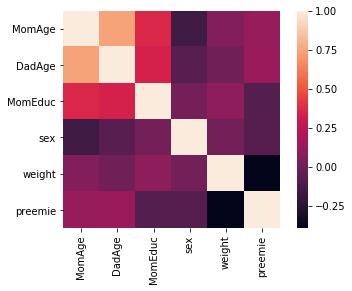

In [5]:
sns.heatmap(df.corr(), square=True);

Построим рапределения признаков с таргетом "недоношенность":

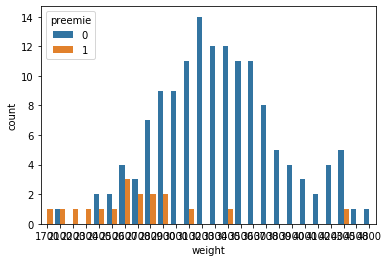

In [6]:
sns.countplot(df.weight.apply(lambda x: x // 100 * 100), hue=df.preemie); 
# вес пришлось округлять до сотен, чтобы график был читаемым 

Видно, что в основном недоношенные имеют вес ниже среднего

На ящике с усами более наглядно:

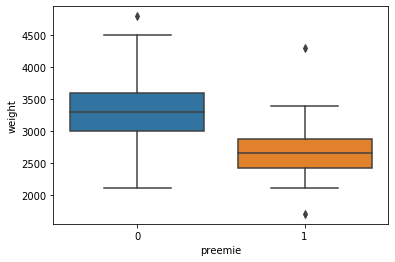

In [7]:
sns.boxplot(y=df.weight.apply(lambda x: x // 100 * 100), x=df.preemie);

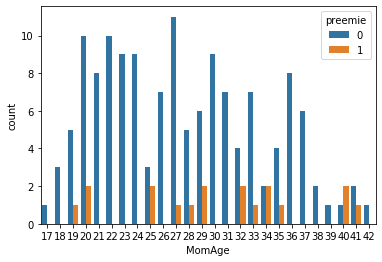

In [8]:
sns.countplot(df.MomAge, hue=df.preemie); 
# каунтплот по возрасту матери

Похоже, что после 30 лет количество недоношенных среди общей массы детей возрастает.
Изучим это подробнее

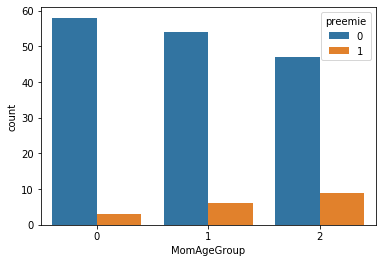

In [16]:
# Разделим матерей по трем возрастным группам: меньше 24 лет, от 24 до 31 и больше 31 года 
df['MomAgeGroup'] = df['MomAge'].apply(lambda x: (2 if x > 31 else (0 if x <= 24 else 1)))
tmp = df[df['preemie'] == 1]
tmp['preemie'] = 0
data = pd.concat([tmp, df])
sns.countplot(data.MomAgeGroup, hue=data.preemie); 

На графике синим обозначено общее количество детей и оранжевым - количество недоношенных в каждой группе. 
Видно, что количество недоношенных с возрастом возрастает, притом как общее количество детей убывает

Посмотрим на зависимость образования матери от ее возраста:

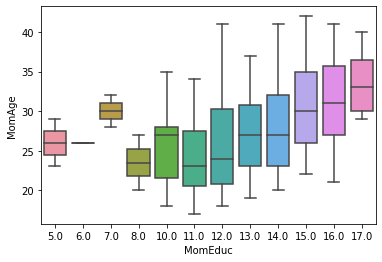

In [26]:
sns.boxplot(x=df.MomEduc, y=df.MomAge);

На графике видно, что образование, равное 7 выделяется из общей картины, начиная с образования, равного 11, видно зависимость между образованием и возрастом. Рассмотрим подробнее матерей в возрасте 30 +- 2 года.

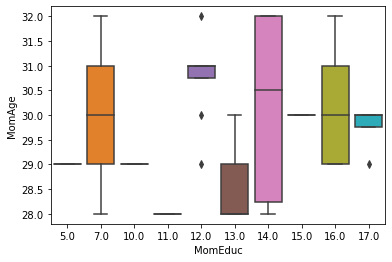

In [35]:
sns.boxplot(x=df.loc[abs(df['MomAge'] - 30) < 3].MomEduc, y=df.loc[abs(df['MomAge'] - 30) < 3].MomAge);

Понятнее не стало. Возможно просто мало данных для матерей с образованием, равным 7.

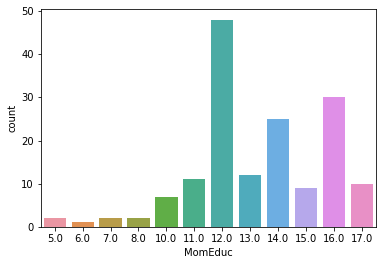

In [46]:
# Построим распределение образования матерей:
sns.countplot(df.MomEduc);

Данных о матерях с низким образованием действительно мало, поэтому нельзя сказать о зависимости.

Попробуем посмотреть на зависимость веса ребенка от его пола:

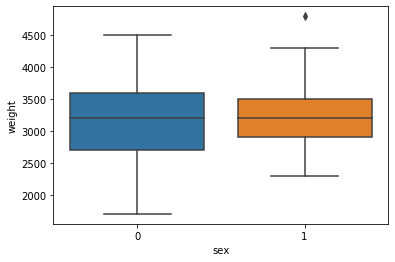

In [11]:
sns.boxplot(y=df.weight.apply(lambda x: x // 100 * 100), x=df.sex);

Видно, что разброс значений веса у мальчиков выше, чем у девочек (крупные и наоборот мелкие девочки встречаются реже)

###### Выводы:

В данных есть зависимости между парами признаков:
возраст матери и возрас отца, вес ребенка и недоношенность, образование матери и ее возраст, образование матери и возраст отца, возраст матери и недоношенность

### 2. Смещение выборочной и исправленной выборочной дисперсий
Функция model_var_bias создает несколько выборок, для каждой подсчитывает исправленную и неисправленную выборочные дисперсии и вычисляет их среднее значение. Затем все то же самое проделывается для разных значений объема выборок. Возвращается два списка значений смещений: для исправленной и неисправленной выборочных дисперсий.

In [2]:
def model_var_bias(beg_sample_size=10, end_sample_size=200, step=5, n_samples=100, distribution='normal'):
    emp_bias=[]
    cor_bias=[]
    for l in range(beg_sample_size, end_sample_size, step): #будут создаваться группы выборок с заданным количеством элементов
        empirical_var = []
        corrected_var = []
        for j in range(n_samples): # n_samples - размер каждой группы выборок
            if distribution == 'normal': # cоздается выборка с нормальным распределением с мат. ожиданием 0 и дисперсией 3
                sample = np.random.normal(0, 3**0.5, l) 
            elif distribution == 'uniform': # создается выборка с равномерным распределением с на [-3, 3] с дисперсией 3
                sample = np.random.uniform(-3, 3, l)
            sigma_n = 0
            for i in range(l):
                sigma_n += (sample[i] - sample.mean())**2
            corrected_var.append(abs(sigma_n / (l - 1))) # для каждой выборки считается исправленная дисперсия
            empirical_var.append(abs((sigma_n / l))) # для каждой выборки считается неисправленная дисперсия
        emp_bias.append(abs(np.mean(empirical_var)) - 3) # для каждой группы выборок считается смещение исправленной дисперсии
        cor_bias.append(abs(np.mean(corrected_var)) - 3) # для каждой группы выборок считается смещение неисправленной дисперсии
    return (emp_bias, cor_bias)

Построим графики смещения исправленной и неисправленной дисперсий, по оси $х -$  количество элементов выборок, по оси $у - $  смещение

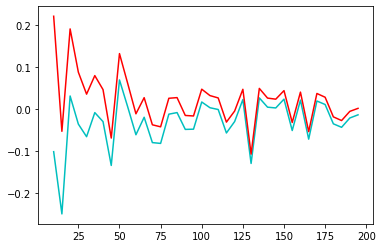

In [9]:
emp_bias, cor_bias = model_var_bias()
sns.lineplot(y=emp_bias, x=[i for i in range(10, 200, 5)], color='c');
sns.lineplot(y=cor_bias, x=[i for i in range(10, 200, 5)], color='r');

По графику видно, что исправленная выборочная дисперсия (красные точки) не смещена, а выборочная дисперсия (синие точки) смещена.

Следующий график демонстрирует, что при устремлении числа элементов выборок к бесконечности, смещения обесих дисперсий сходятся к нулю.

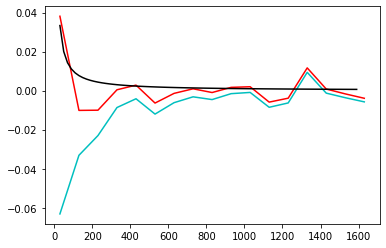

In [28]:
emp_bias, cor_bias = model_var_bias(beg_sample_size=30, end_sample_size=1700, step=100, n_samples=500)
sns.lineplot(y=emp_bias, x=[i for i in range(30, 1700, 100)], color='c');
sns.lineplot(y=cor_bias, x=[i for i in range(30, 1700, 100)], color='r');
x = [i for i in range(30, 1600, 20)]
y = [1/i for i in range(30, 1600, 20)]
sns.lineplot(x, y, color='black');

На графике черным обозначена функция $y(x) = \dfrac{1}{x}$, со скоростью которой сходится смещение

# Привести пример распределения, для которого не выполняется ЦПТ

Следующая функция рисует эмперическую функцию распределения по заданной выборке:

In [40]:
def distribution_plot(X, n_fragments=100, color='r'):
    y = []
    x = []
    len_X = round(max(X) - min(X)) # считаем длину отрезка значений элементов выборки
    for i in range(n_fragments):
        point = min(X) + (len_X / n_fragments) * i # выбираем точку, значение функции распределения в которой будем вычислять
        count = 0
        for j in range(len(X)):
            if X[j] <= point: # считаем количество элементов выборки, которые меньше заданного числа
                count += 1
        y.append(count / len(X)) 
        x.append(point)
    sns.lineplot(x=x, y=y, color=color);

Теперь создадим две выборки: первая нормально распределена, а вторая состоит из средних выборочных распределения Коши:

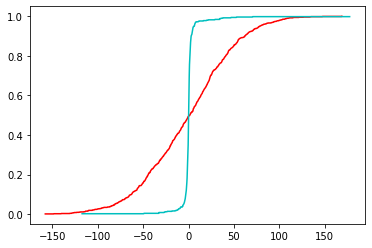

In [100]:
sample_1 = np.random.normal(0, 50, 1000) # создали выборку с нормальным распределением
distribution_plot(sample_1, 1000) # нарисовали функцию распределения

sample_2 = [] # создаем выборку из средних выборочных распределения Коши
for i in range(500):
    X = np.random.standard_cauchy(100) # выборка с распределением Коши
    sample_mean = sum(X)/len(X) # выборочное среднее созданной выборки
    sample_2.append(sample_mean) 
distribution_plot(sample_2, 1000, color='c') # нарисовали функцию распределения

Чтобы доказать, что голубая функция распределения имеет не нормальное распределение, воспользуемся методом qqplot $-$ квантиль-квантиль. Этот метод заключается в сравнении двух распределений путем построения их квантелей друг против друга. Если распределения похожи, то точки на графике должны приблизительно на прямой $y = x$. 

Посмотрим на наши данные:

In [87]:
import statsmodels.api as sm

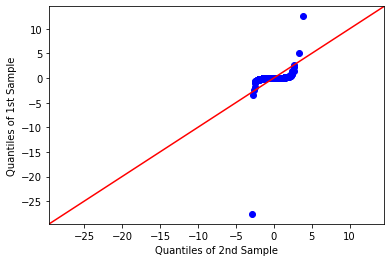

In [88]:
pp_x = sm.ProbPlot(np.array(sample_2), fit=True)
pp_y = sm.ProbPlot(np.array(sample_1), fit=True)
fig = pp_x.qqplot(line='45', other=pp_y)
plt.show()

На графике видно, что распределения разные, значит ЦПТ не выполняется.